In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


Github Repo: https://github.com/alya4065/supervise-learning-final-project/tree/main

In this project, we will train a variety of supervised machine learning models on a heart failure dataset to predict whether a person will suffer from a heart condition. This dataset includes features such as Age, Sex, Type of Chest Pain, Cholesterol levels, Resting blood pressure, ST segment shift, etc. 

Our models will be performing binary classification to determine whether an individual is at risk of having a heart disease.

We first read the dataset which can be found in the following link 

In [6]:
df = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We will start by preprocessing the data.

First, we will check if there are any empty rows

In [8]:
# Check for empty rows 

df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

We see that there are no empty rows.

We will now check the basic statistics of the dataset to make sure there are no odd values such as a negative age value. 

In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


We can see that there are some outlier values in RestingBP and Cholesterol. Namely, there are values of 0 which make no physical sense. So we will proceed to delete these rows.

In [10]:
# Delete rows with RestingBP = 0 or Cholesterol = 0
df = df[df['RestingBP'] != 0]
df = df[df['Cholesterol'] != 0]

We can see that the columns Sex, ChestPainType, RestingECG, ExerciseAngina and ST_Slope are categorical variables. 

We will proceed to process each column one at a time.

First, we check for the column Sex

In [11]:
# Check the number of males vs females
df['Sex'].value_counts()

# We can see that there are way more males in this dataset than females which could lead 
# to issues in the model training since it will create bias. We will deal with this if 
# this affects our model significantly. 

# We can also see that the variables take the value of M and F instead of 0 and 1 so we 
# will map M to 0 and F to 1.

df['Sex'] = df['Sex'].map({'M':0, 'F':1})

Now we will check for ChestPainType

In [12]:
# Check the possible entries for ChestPainType to see whether this categorical variable
# is binary or multiclass
df['ChestPainType'].value_counts()

# We see that there are four classes. We could proceed with encoding, that is, assign
# each value to a number from 0 to 3 however this could introduce undesired ordering.
# Thus, we will just continue with one-hot-encoding which sets each value as a binary column

df = pd.get_dummies(df, columns=['ChestPainType'], dtype=int, drop_first=True)

Since this process is repetitive we will do the same for the rest of the categorical variables

In [13]:
# Apply one-hot-encoding to RestingECG
df = pd.get_dummies(df, columns=['RestingECG'], dtype=int, drop_first=True)
# Apply binary mapping to ExerciseAngina
df['ExerciseAngina'] = df['ExerciseAngina'].map({'N':0, 'Y':1})
# Apply one-hot-encoding to ST_Slope
df = pd.get_dummies(df, columns=['ST_Slope'], dtype=int, drop_first=True)

Now that we have done some data cleaning, we will proceed to create data visualizations to see the relationship of the variables with one another to find out whether there is correlation between them. 

Moreover, data visualization will also help us to see whether the numerical values are skewed and if so we could apply scaling methods.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Figure size 2000x1000 with 0 Axes>

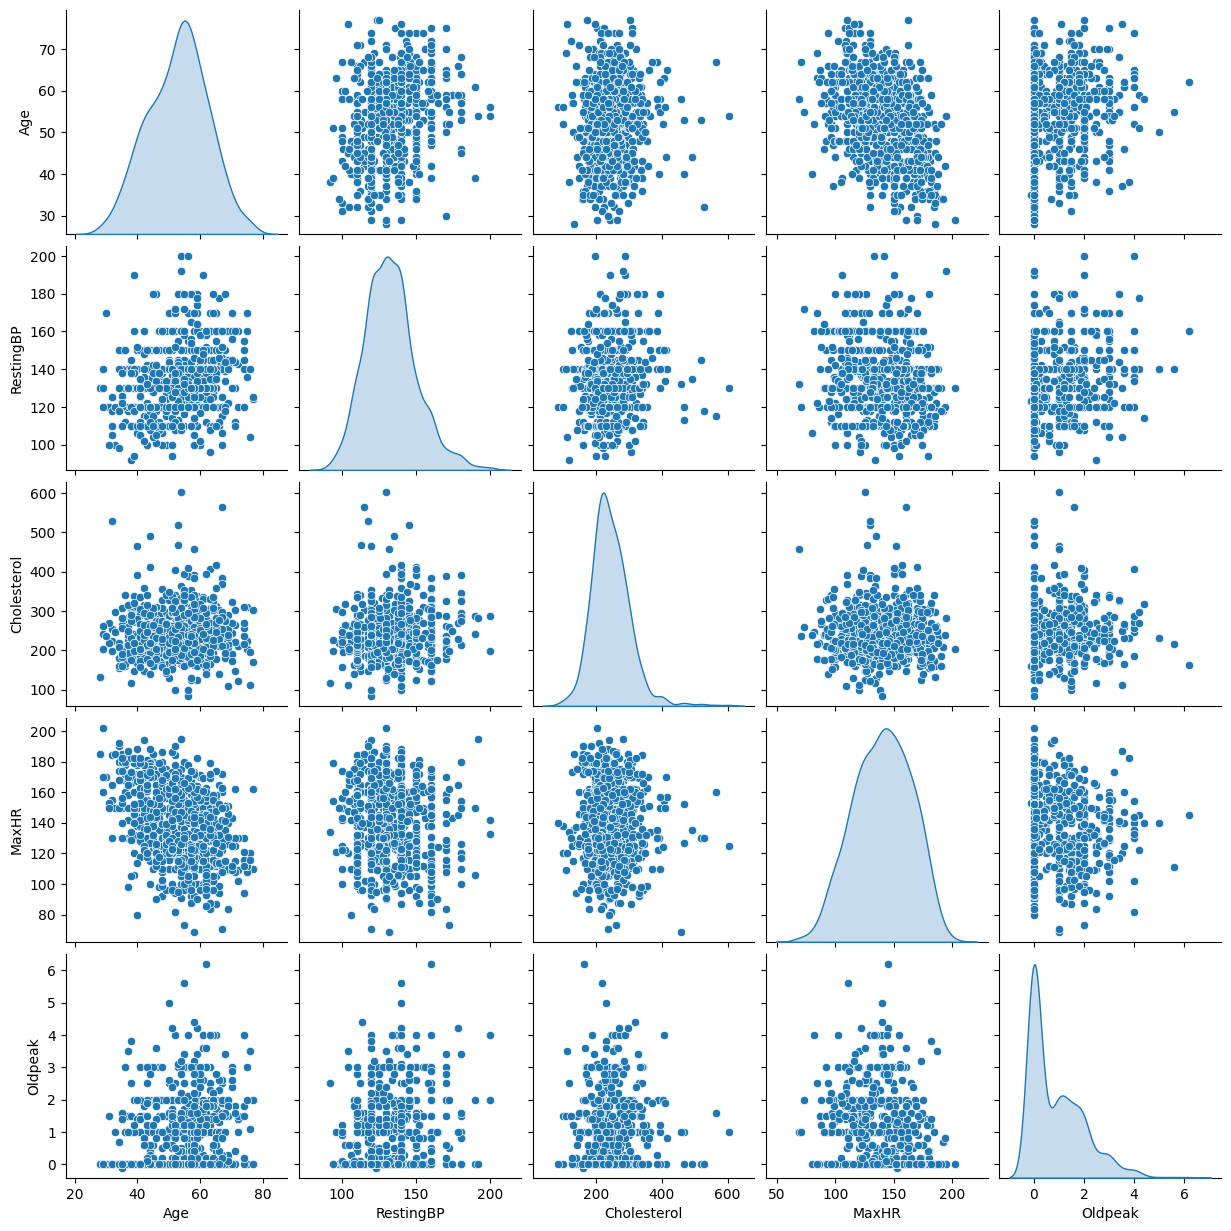

In [14]:
# We first start with a pair plot to see the relationship between pairs of variables

plt.figure(figsize=(20,10))
sns.pairplot(data=df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']], diag_kind='kde')

We see that there is no visible correlation between the numerical variables there seems to be a random scatter between them. 

We will now proceed with a numerical approach by utilizing a heatmap to get the correlation between the numerical variables.

<Axes: >

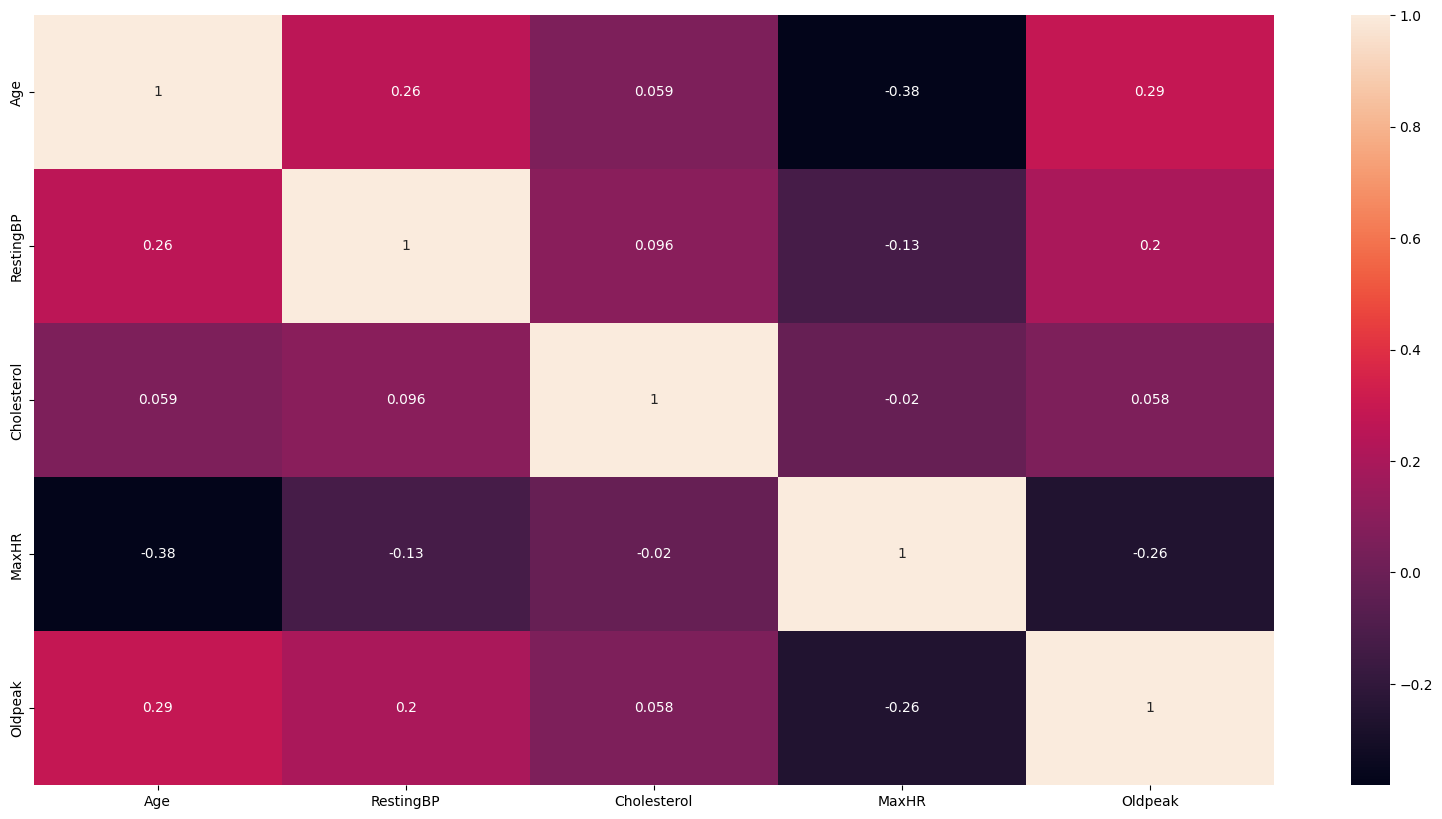

In [15]:
plt.figure(figsize=(20,10))
sns.heatmap(df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']].corr(),annot=True)

The correlations agree with the pair plot conclusions that there does not seem to be any strong correlations between the variables.

However, we can see that these numerical variables have different ranges in their values. For instance, age ranges from 28 to 77 while Cholesterol ranges from 85 to 603. Thus, we will perform a scaling on all numerical values so that they range from 0 to 1. 


In [16]:
# Scaling numerical variables so that they range from 0 to 1

scaler = MinMaxScaler()

df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']] = scaler.fit_transform(df[['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']])

Now, we can see that most of the values of 'Oldpeak' are 0 and by looking at the diagonal density graph of this variable, we can see that it is positively skewed. Thus, this variable might not come with significant explanatory power and we should remove from our dataset. 

In [17]:
df = df.drop('Oldpeak', axis=1)

Now that we have preprocessed the features, we will start by training a model. As a first step, we will use scikit-learn RandomForestClassifier which will allow us to get the feature importance for each variable. Since we are going to use RandomForestClassifer mainly to get feature importance, then we will not split the dataset

In [18]:
# Split target column and feature columns
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

# Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X,y)

feature_importance = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})
importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance
13,ST_Slope_Up,0.183902
12,ST_Slope_Flat,0.127996
5,MaxHR,0.120574
0,Age,0.106452
6,ExerciseAngina,0.097364
3,Cholesterol,0.091573
2,RestingBP,0.088410
1,Sex,0.051253
7,ChestPainType_ATA,0.042150
8,ChestPainType_NAP,0.032590


Now that we have the importance of each feature, we will get started by fitting a simple LogisticRegression model. 

We will first fit a full model which includes all the features

In [51]:
X = df.drop(['HeartDisease'], axis = 1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

logistic_regressor = LogisticRegression(max_iter=100)

logistic_regressor.fit(X_train,y_train)

y_pred = logistic_regressor.predict(X_test)
y_prob = logistic_regressor.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
print(roc_auc)

0.8866666666666667
0.955072205384204


We get a solid score of 0.8866. However, we know that some features do not seem to be important. We will fit the model with the bottom 3 features in importance removed. 

In [65]:
X = df.drop(['HeartDisease','RestingECG_ST','FastingBS', 'ChestPainType_TA'], axis = 1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

logistic_regressor = LogisticRegression(max_iter=100)

logistic_regressor.fit(X_train,y_train)

y_pred = logistic_regressor.predict(X_test)
y_prob = logistic_regressor.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(accuracy)
print(roc_auc)

0.92
0.9575681939739704


We see an improvement of about 3 percent! 

Now, let's try more sophisticated models to see if we can achieve higher scores. We will fit Random Forest Classifier, XGBoost, and Support Vector Classifier.

We will use Grid Search for each method to find the hyperparameters that optimize the models the most.

We will begin with Random Forest Classifier

In [53]:
X = df.drop(['HeartDisease'], axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

param_grid = {
    'n_estimators': [10,100,1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1,2,5],
    'min_samples_leaf': [1,5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 1000}


Now that we have the best hyperparameters, we are going to fit a random forest classifier model with these hyperparameters and see what score we get.

In [66]:
rf_classifier = RandomForestClassifier(max_depth = 5, min_samples_leaf = 1, max_features= 'sqrt',
                                       n_estimators= 1000, random_state=42)
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(accuracy)
print(roc_auc)

0.9
0.9463362453200215


We see that there's a 0.6% accuracy increase from the simple logistic regression model. Let's see if we can get an even higher accuracy score by removing the features with low importance


In [23]:
X = df.drop(['HeartDisease','RestingECG_ST','FastingBS', 'ChestPainType_TA'], axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

param_grid = {
    'n_estimators': [10,100,1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1,2,5],
    'min_samples_leaf': [1,5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)


{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


In [55]:
rf_classifier = RandomForestClassifier(max_depth = 5, min_samples_leaf = 1, max_features= 'sqrt',
                                       n_estimators= 100, random_state=42)
rf_classifier.fit(X_train,y_train)

y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
print(roc_auc)

0.9133333333333333
0.95025851310394


We actually get a lower score. This might be due to the fact that the random forest classifier is underfitting because of the lack of features. 

Thus, moving forward, we will keep the random forest classifier with all the predictors.

Now, we will train a gradient boosting model, namely, a XGBoost classifier model. 
We will use all the predictors for the sake of preventing underfitting but we will use gridsearch to find the best hyperparameters.


In [25]:
X = df.drop(['HeartDisease'], axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

param_grid = {
    'booster': ['gbtree','gblinear','dart'],
    'n_estimators': [10, 100, 1000],
    'learning_rate': [0.1,0.3,0.5]
}

grid = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)

{'booster': 'gblinear', 'learning_rate': 0.1, 'n_estimators': 10}


In [56]:
xgb_classifier = XGBClassifier(objective='binary:logistic', n_estimators = 10,
                               learning_rate = 0.3, random_state = 42)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)
y_prob = xgb_classifier.predict_proba(X_test)[:,1]
accuracy_score(y_test,y_pred)

roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)

print(accuracy)
print(roc_auc)

0.8666666666666667
0.9405419860937779


We see that we get a lower score with Gradient boost compared to a simpler Random Forest Classifier. So our best option is to opt for the latter. However, let's go ahead and fit a K-neighbors classifier and a Support Vector Classifier to test whether we can get even more accurate models. Again, we will use grid search to train the models with the hyperparameters that optimize the models the most.

In [27]:
# Set neighbors to odd numbers since the dataset has an even number of samples
param_grid = {
    'n_neighbors': [5, 15, 31],
    'weights': ['uniform', 'distance']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)

{'n_neighbors': 31, 'weights': 'uniform'}


In [57]:
knn = KNeighborsClassifier(n_neighbors = 31, weights = "uniform")
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]
accuracy_score(y_test,y_pred)

roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)

print(accuracy)
print(roc_auc)

0.9133333333333333
0.9559636298805492


We can see that while the roc auc is slightly greater than that of the random forest, the accuracy score is lower. Thus, the random forest is still the best algorithm thus far.

Lastly, we will train a support vector machine

In [30]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 0.5, 1, 1.5, 2],
    'gamma': [0.1, 0.5, 1, 1.5, 2]
}
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5)
grid.fit(X_train,y_train)

print(grid.best_params_)


{'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}


In [58]:
svc = SVC(kernel = 'rbf', gamma = 1, C = 0.5, random_state=42, probability = True)

svc.fit(X_train,y_train)

y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]
accuracy_score(y_test,y_pred)

roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test,y_pred)

print(accuracy)
print(roc_auc)

0.92
0.9474059547156356


Summary/Conclusion:

We obtained a dataset from https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction that contains features such as age, sex, resting blood pressure, cholesterol levels, etc, to help us train a binary classification model to determine whether a person will suffer from heart failure or not. 

We first preprocessed the dataset by converting the multiclass categorical variables into individual binary variables using one-hot-encoding. We also converted the binary varialbes with string values into 0 and 1's. 

After that we proceeded with data visualization where we used a pair plot to determine potential correlations between our variables. However, we did not find any. Additionally, we used a correlation heatmap to verify these initial observations. We confirmed that the strongest correlation was of around -0.38 between age and heart rate which is not sufficient to justify the deletion of either feature. However, we did notice that the feature "OldPeak" had mostly values of 0 which as shown in its diagonal pairplot, caused a positive skewed feature. Not only that but it also had some slight correlations with other features (about 0.2 or so). So we proceeded to delete this feature.

Moreover, we saw that our numerical features had different ranges. For instance, age ranged from 28 to 77 while cholesterol ranged from 0 to 603. So we applied feature scaling so that our numerical values go from 0 to 1. Furthermore, there were values for cholesterol and fasting blood sugar that made no physical sense such as having a value of 0. Thus, we deleted those rows as well. 

After we processed our dataset, we decided to fit a random forest classifier with all the features to leverage the feature importance feature of this library. We found out that three of the variables, namely, RestingECG_ST, FastingBS, and ChestPainType_TA were not that significant, and in fact, they could add some noise to our models which could potentially reduce their accuracy. 

Then, we proceeded to train two simple logistic regression models, one with all features and one with the bottom 3 least significant features removed. The partial model had a 92% accuracy score while the full model had an 89%. Moreover, we also used the ROC AUC to score our models. For the simple logistic models, the full model has an ROC AUC of 95.5% while the partial model had an ROC AUC of 95.7%.

While the simple logistic model had solid scores, we tried to come up with a better model. Thus, we trained a random forest classifier, an XGBoost classifer, a KNN classifier, and a Support Vector Classifier. For each of these models, we utilized grid search to find the best hyperparameters possible. As a summary, XGBoost performed the worst, with an accuracy score of 0.86 and a ROC AUC of 0.94, sigfinicantly worse than the simple logistic regression model. On the other hand, the KNN classifier and SVC had score values similar to the partial simple logistic model. Our best model in terms of accuracy was the random forest classifier with all features with an accuracy score of 92.6% , 0.6% better than the partial simple logistic regression model. However, its ROC AUC was slightly worse at 95.2%. But because our target column was balanced, we can make the argument that because of the slight improvement in accuracy, the random forest classifier with all variables is our best model

Our XGBoost classifier model had the worst performance, however, this could be caused by not finding the best hyperparameters. For future reference, one could spend more time in hyperparatemer tuning which should result in better scores.

Citation:

Fedesoriano. (2021, September 10). Heart failure prediction dataset. Kaggle. https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction 